In [1]:

import torch
import torch.optim as optim
import matplotlib.pyplot as plt

##############################################
# Explanation:
# In this tutorial, we demonstrate how to selectively disable autograd
# during validation or inference using:
#   - torch.no_grad()
#   - torch.set_grad_enabled(is_train)
#
# This is helpful for saving memory and computation time, especially
# with large models where building unnecessary computation graphs
# can be costly.
##############################################


In [2]:
def model(t_u, w, b):
    """
    Simple linear model:
      predicted Celsius = w * t_u + b
    """
    return w * t_u + b

def loss_fn(t_p, t_c):
    """
    Mean Squared Error (MSE) loss:
      MSE = average((t_p - t_c)^2)
    """
    return ((t_p - t_c)**2).mean()


In [3]:
# We'll reuse the thermometer data from the chapter example.
t_c_list = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u_list = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c_list, dtype=torch.float)
t_u = torch.tensor(t_u_list, dtype=torch.float)

# For demonstration, we split into training and validation sets (80/20).
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u   = t_u[val_indices]
val_t_c   = t_c[val_indices]

# Normalize inputs by a small factor (e.g., 0.01) to stabilize gradients
train_t_un = 0.01 * train_t_u
val_t_un   = 0.01 * val_t_u


In [4]:
def training_loop_no_grad(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    """
    Train the model on the training data only, while evaluating the validation loss
    inside a 'torch.no_grad()' block to avoid building a computation graph for val_loss.
    """
    train_losses = []
    val_losses   = []
    
    for epoch in range(1, n_epochs+1):
        # Forward pass (training data)
        train_t_p = model(train_t_u, params[0], params[1])
        train_loss = loss_fn(train_t_p, train_t_c)
        train_losses.append(train_loss.item())
        
        # Forward pass (validation data) without building a computation graph
        with torch.no_grad():
            val_t_p = model(val_t_u, params[0], params[1])
            val_loss = loss_fn(val_t_p, val_t_c)
            val_losses.append(val_loss.item())
            
            # Confirm val_loss doesn't require gradients
            assert not val_loss.requires_grad, "val_loss should not require grad."
        
        # Backward pass on the training loss only
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Print progress every 500 epochs or first few
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch:4d}, Training loss {train_loss.item():.4f}, "
                  f"Validation loss {val_loss.item():.4f}")
    
    return params, train_losses, val_losses


In [5]:
def calc_forward(t_u, t_c, params, is_train=True):
    """
    If is_train=True, we track gradients; if is_train=False, we do not.
    This is useful for toggling between training and inference modes
    in the same function.
    """
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, params[0], params[1])
        loss = loss_fn(t_p, t_c)
    return loss


In [6]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
optimizer = optim.SGD([params], lr=1e-2)

print("=== Training with 'torch.no_grad()' for Validation ===")
trained_params, train_losses, val_losses = training_loop_no_grad(
    n_epochs=3000,
    optimizer=optimizer,
    params=params,
    train_t_u=train_t_un,
    val_t_u=val_t_un,
    train_t_c=train_t_c,
    val_t_c=val_t_c
)

print("Trained Parameters:", trained_params.detach().numpy())


=== Training with 'torch.no_grad()' for Validation ===
Epoch    1, Training loss 209.9488, Validation loss 12.4362
Epoch    2, Training loss 201.3929, Validation loss 12.9096
Epoch    3, Training loss 193.2850, Validation loss 13.5339
Epoch  500, Training loss 38.1064, Validation loss 110.2369
Epoch 1000, Training loss 30.7197, Validation loss 79.1661
Epoch 1500, Training loss 24.8324, Validation loss 55.7851
Epoch 2000, Training loss 20.1401, Validation loss 38.3848
Epoch 2500, Training loss 16.4003, Validation loss 25.6188
Epoch 3000, Training loss 13.4197, Validation loss 16.4283
Trained Parameters: [33.64724   -6.0933723]


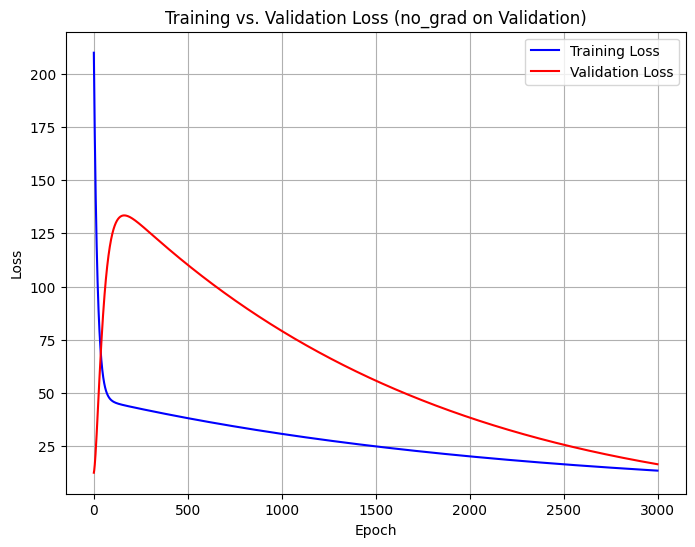

In [7]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses,   label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss (no_grad on Validation)")
plt.legend()
plt.grid(True)
plt.show()

# Explanation:
#  - The training loss is computed with autograd, so we can backpropagate.
#  - The validation loss is computed under 'torch.no_grad()', so no graph is built.
#  - This can save memory/time in large models, since we won't need
#    to store intermediate results for backprop on validation data.


In [8]:
train_loss_demo = calc_forward(train_t_un, train_t_c, trained_params, is_train=True)
val_loss_demo   = calc_forward(val_t_un,   val_t_c,   trained_params, is_train=False)

print("\n=== Demonstration of set_grad_enabled ===")
print("Train Loss (requires_grad):", train_loss_demo.requires_grad)
print("Val Loss (requires_grad):  ", val_loss_demo.requires_grad)

# Explanation:
#  - When is_train=True, train_loss_demo.requires_grad should be True.
#  - When is_train=False, val_loss_demo.requires_grad should be False.
# This toggling is useful if you have a single function that handles both training
# and inference phases.


=== Demonstration of set_grad_enabled ===
Train Loss (requires_grad): True
Val Loss (requires_grad):   False
